## Totale N.
### Esercizio 3 punto 1
Alessandro Lodi<br>
Matricola 274425

### Notebook Init

In [1]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class args:
    filename = "graph.gml"
    scale = 40
    figsize = 5,5

In [4]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

### Drawing functions

In [5]:
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        
    plt.axis('off')
    plt.show()

In [6]:
# Graph reading
basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 10 nodes and 45 edges


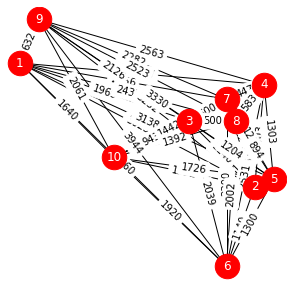

In [7]:
DrawInitG(G, withedges=True)

## Minimum Spanning Tree formulation

$$
x_{ij} = \begin{cases} 1 \text{ if edge } e=\{i,j\} \text{ is selected} \\
0 \text{ otherwise.}\end{cases}
$$

$$
\min \sum_{e=\{i,j\} \in E} c_{ij} x_{ij} \\
\sum_{e=\{i,j\} \in E} x_{ij} = |V| - 1 \\
\sum_{e=\{i,j\} \in E(S)} x_{ij} \le |S| - 1, \;\; \forall S \subset V, 2 < |S| \le |V| - 1  \\
x \le 1 \\ 
x \ge 0
$$

In [8]:
mst = gb.Model()

# Decision Variables
x = mst.addVars(G.edges(), 
                obj=[G[u][v]['cost'] for u,v in G.edges()],
                ub = 1.0,
                vtype=gb.GRB.CONTINUOUS,
                name='x')


# Cardinality constraint
mst.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

# Subtour Elimination Constraints
sec = 0
for i in powerset(G.nodes()):
    if len(i) > 2 and len(i) <= G.number_of_nodes() - 1:
        sec += 1
        S = G.subgraph(i)
        if S.number_of_edges() > S.number_of_nodes() - 1:
            # Add only edges existing in S 
            mst.addConstr(gb.quicksum(x[i,j] if (i,j) in x else x[j,i] for i,j in S.edges())
                          <= S.number_of_nodes() - 1, 'Sec' + str(sec))
            
print ("Number of Subtour Elimination Constraints:", sec)
            
mst.update()
mst.write('mst.lp')

Academic license - for non-commercial use only - expires 2021-07-30
Using license file /opt/gurobi/gurobi.lic
Number of Subtour Elimination Constraints: 967


In [9]:
mst.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 968 rows, 45 columns and 11475 nonzeros
Model fingerprint: 0x211b7527
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 9e+00]
Presolve time: 0.01s
Presolved: 968 rows, 45 columns, 11475 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0070000e+03   1.024000e+03   0.000000e+00      0s
       8    6.7350000e+03   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.03 seconds
Optimal objective  6.735000000e+03


Optimal solution: 6735.0


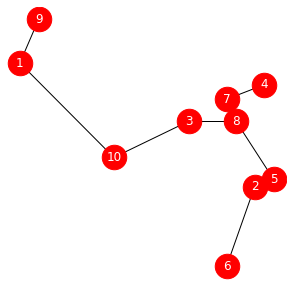

In [10]:
print ("Optimal solution:", mst.objVal)
DrawSol(G,x)

## Subtour Elimination Constraints formulation (separation problem)

$$
\max \sum_{e=\{i,j\} \in E} x^*_e w_{ij} - \sum_{j \in V} z_j \\
w_{ij} - z_i \le 0  \;\;\; \forall \{i,j\} \in E\\
w_{ij} - z_j \le 0 \;\;\; \forall \{i,j\} \in E\\
z_k = 1\\
0 \le z \le 1, 0 \le w \le 1
$$

In [11]:
def SECseparation (x, G, kappa):
    SECsep = gb.Model()
    
    # Display of gurobi log switched off
    SECsep.Params.OutputFlag = 0

    # Decision Variables
    w = SECsep.addVars(G.edges(), 
                       obj=[x[u,v].x for u,v in G.edges()],
                       ub = 1.0,
                       vtype=gb.GRB.CONTINUOUS, name='w')
        
    z = SECsep.addVars(G.nodes(),
                       obj = -1.0,
                       ub = 1.0,
                       vtype=gb.GRB.CONTINUOUS, name='z')

    
    # Objective function
    SECsep.ModelSense = -1
    

    # Constraints
    SECsep.addConstrs((w[i,j] - z[i] <= 0 \
                       for i,j in G.edges()), name = 'WZ1')
    
    SECsep.addConstrs((w[i,j] - z[j] <= 0 \
                       for i,j in G.edges()), name = 'WZ2')
    
    SECsep.addConstr(z[kappa] == 1, name="Fixing")
    
    SECsep.update()
    SECsep.write('sep.lp')

    SECsep.optimize()

    if (SECsep.objVal) > -1.0:
        SEC = [i for i in G.nodes() if z[i].x > 0.1]
        return True, SEC
    else:
        return False, None

## Master problem 

The master problem now contains only the cardinality constraint

In [12]:
mst = gb.Model()

# Decision Variables
x = mst.addVars(G.edges(), obj=[G[u][v]['cost'] for u,v in G.edges()], ub = 1.0,\
                vtype=gb.GRB.CONTINUOUS, name='x')

# Cardinality constraint
mst.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

mst.update()
mst.write('mst.lp')

## Cutting plane algorithm

At each iteration, after the resolution of the master LP (note, the relaxation) 
a sequence of separation problems are solved
and if there exists a violated SEC then it is added to the master. 

Current solution value: 5016.0


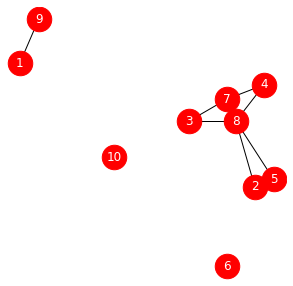

Found violated subtour. S = [1, 2, 3, 4, 5, 7, 8]
Current solution value: 5284.0


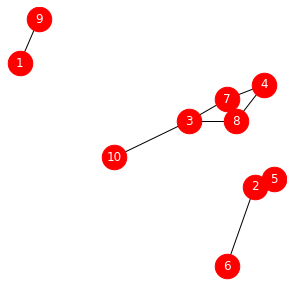

Found violated subtour. S = [1, 3, 4, 7, 8]
Current solution value: 5595.0


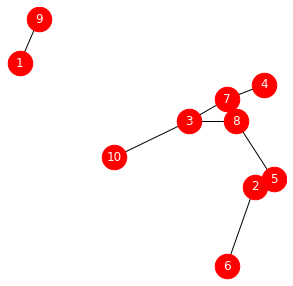

Found violated subtour. S = [2, 3, 5, 7, 8]
Current solution value: 5678.0


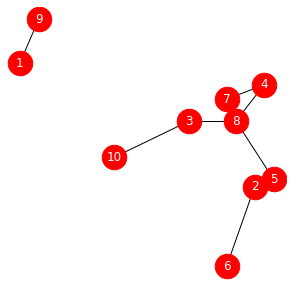

Found violated subtour. S = [2, 4, 5, 7, 8]
Current solution value: 5839.5


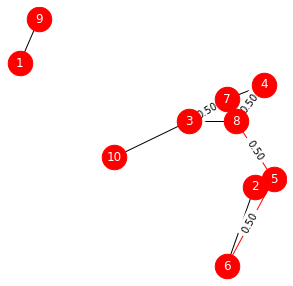

Found violated subtour. S = [2, 3, 4, 5, 6, 7, 8]
Current solution value: 6011.5


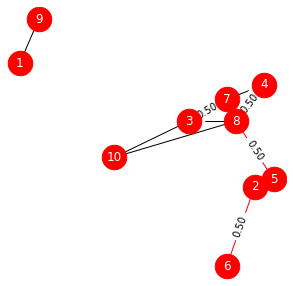

Found violated subtour. S = [1, 3, 4, 7, 8, 10]
Current solution value: 6171.5


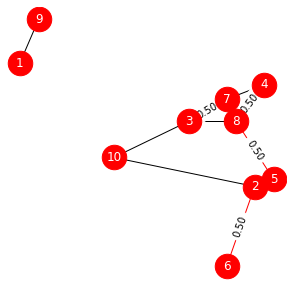

Found violated subtour. S = [1, 2, 3, 4, 5, 7, 8, 10]
Current solution value: 6253.0


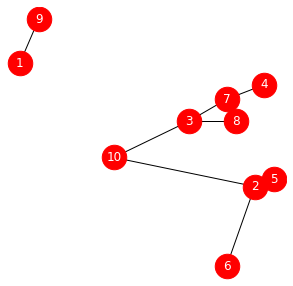

Found violated subtour. S = [2, 3, 7, 8, 10]
Current solution value: 6336.0


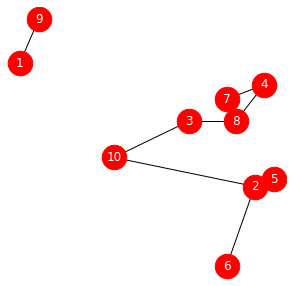

Found violated subtour. S = [2, 3, 4, 7, 8, 10]
Current solution value: 6427.0


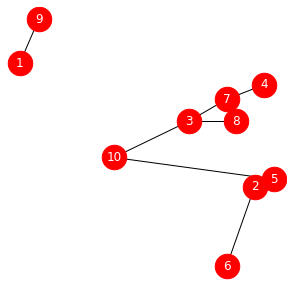

Found violated subtour. S = [2, 3, 5, 7, 8, 10]
Current solution value: 6510.0


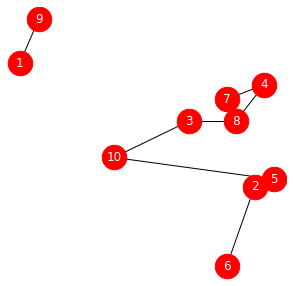

Found violated subtour. S = [2, 3, 4, 5, 7, 8, 10]
Current solution value: 6621.0


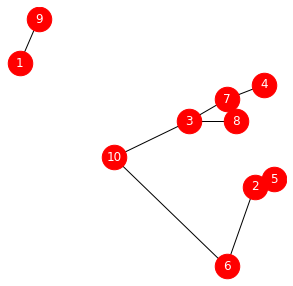

Found violated subtour. S = [2, 3, 6, 7, 8, 10]
Current solution value: 6678.0


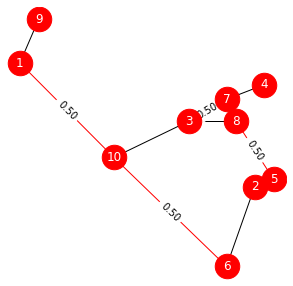

Found violated subtour. S = [2, 3, 5, 6, 7, 8, 10]
Current solution value: 6704.0


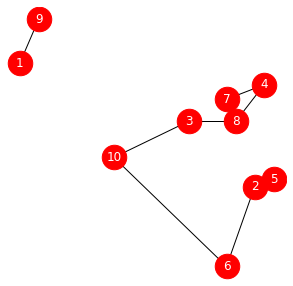

Found violated subtour. S = [2, 3, 4, 6, 7, 8, 10]
Current solution value: 6719.5


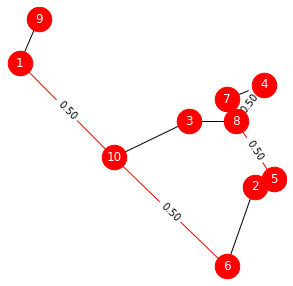

Found violated subtour. S = [2, 3, 4, 5, 6, 7, 8, 10]
Current solution value: 6735.0


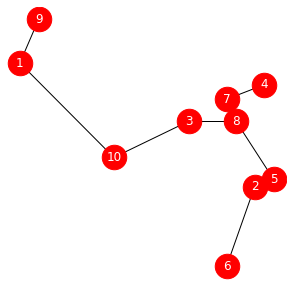

In [13]:
cont = True
sec = 1
mst.Params.OutputFlag = 0

while cont: 
    mst.optimize()
    print ("Current solution value:", mst.objVal)

    DrawSol(G,x)

    cont = False
    for u in G.nodes():
        status, S = SECseparation(x, G, u)
        if status:
            cont = True
            SEC = G.subgraph(S)
            
            print ("Found violated subtour. S =", SEC.nodes())
            
            # SEC Constraint is added
            mst.addConstr(gb.quicksum(x[i,j] if (i,j) in x else x[j,i] for i,j in SEC.edges()) \
                                      <= SEC.number_of_nodes() - 1, 'Sec' + str(sec))

            sec += 1     
            break